In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import scipy.stats as stats
#from scipy.stats import beta
from math import lgamma
from numba import jit #just in time compiling
from mpmath import betainc

from google.cloud import bigquery
from google.cloud import storage
from google_auth_oauthlib import flow

## Table of Content
* [Cleaning & Preparation](#Cleaning-&-Preparation)
    * [Read Table](#Read-Table)

* [One Example](#One-Example)
    * [Distribution](#Distribution)
    * [Fancy Visualisation](#Fancy-Visualisation)
    * [Calculate Uplift](#Calculate-Uplift)

* [Productionize](#Productionize)

* [Appendix](#Appendix-&-Notes)

## Cleaning & Preparation

### Read Table
[Back to top](#Table-of-Content)

In [12]:
df_raw=pd.read_csv('AB Testing example data.csv')

In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
sent_week     76 non-null object
City          76 non-null object
audience      76 non-null object
test_group    76 non-null object
opens         76 non-null int64
clicks        76 non-null int64
dtypes: int64(2), object(4)
memory usage: 3.7+ KB


This is a raw table containing all test results from the two chosen city for each audience. Only `Open` and `Click` measures are chosen here for comparing A/B Results.

In [13]:
#Pivot test group
df=df_raw.pivot_table(values=['opens', 'clicks'], index=['sent_week','city','audience'], 
                          columns='test_group', aggfunc = 'sum').reset_index().fillna(0)
df.columns = df.columns.to_series().str.join('_') #flattern multi-index
df.rename(columns={"sent_week_": "sent_week", "city_": "city", "audience_": "audience"}, inplace=True)

In [14]:
df.head()

,sent_week,city,audience,clicks_control,clicks_target,opens_control,opens_target
0,10/1/21,AAA,female,38,971,295,6616
1,10/1/21,AAA,male,19,274,294,3745
2,10/1/21,BBB,female,11,288,281,5627
3,10/1/21,BBB,male,12,86,392,3663
4,13/12/20,AAA,female,27,421,269,5821


## One Example
[Back to top](#Table-of-Content)

Let's pick the `AAA: female` test on the 10th Jan 2021 as an example. 

Code taken from V, Lavorini (2019) https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a

### Distribution
[Back to top](#Table-of-Content)

In [15]:
#This is the known data: open(impressions) and click(conversions) for the Control and Target set
opens_C, clicks_C = 295, 38 #C for control
opens_T, clicks_T = 6616, 971 #T for target

#here we create the Beta functions for the two sets
a_C, b_C = clicks_C+1, opens_C-clicks_C+1 #alpha is success (click), while beta is failure
beta_C = stats.beta(a_C, b_C)
a_T, b_T = clicks_T+1, opens_T-clicks_T+1
beta_T = stats.beta(a_T, b_T)

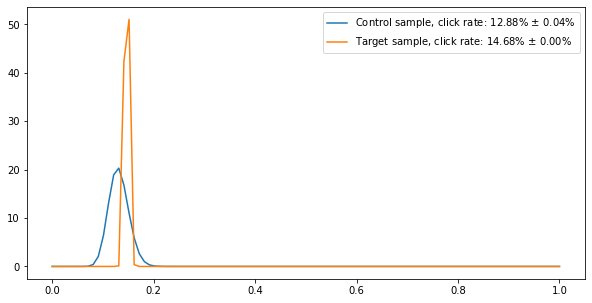

In [16]:
def calc_beta_mode(a, b):
    '''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

def plot(betas, names, linf=0, lsup=1):
    '''this function plots the Beta distribution'''
    x=np.linspace(linf, lsup, 100) #Return evenly spaced numbers over a specified interval, 100 steps from 0 to 1
    
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points
        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x, y, label=f"{name} sample, click rate: {y_mode:0.2%} $\pm$ {y_var:0.2%}")

    plt.legend()
    #plt.ylabel('density')
    #plt.xlabel('click_rate')
    plt.show()

plt.figure(figsize=(10,5))
plot([beta_C, beta_T], names=["Control", "Target"])

Similar to the frequentist approach, the Test for AAA's female is 1.8% (in terms of click rate) higher than the control. This is our lift, but now we need to test how trustful this lift is.

First we will use Monte Carlo Simulation to generate some fancy visualisation.

### Fancy Visualisation
[Back to top](#Table-of-Content)

We will borrow the code from V, Lavorini (2019) https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a

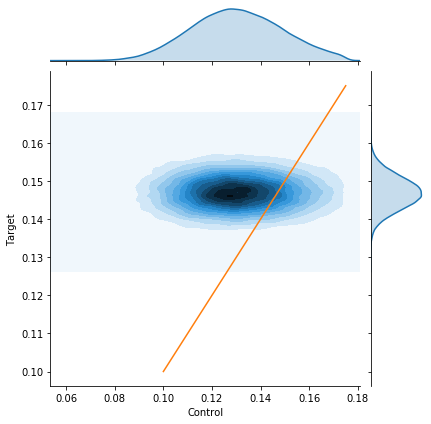

In [20]:
val_C=np.random.beta(a_C, b_C, 100000) #Monte Carlo sample 100k from each distribution
val_T=np.random.beta(a_T, b_T, 100000)
vals=np.vstack([val_C, val_T]).T

limit=0.175 #not to plot the entire area

df_plot=pd.DataFrame(vals, columns=['Control', 'Target'])
df_plot=df_plot[df_plot['Control']<limit]
df_plot=df_plot[df_plot['Target']<limit]
g=sns.jointplot(x=df_plot.Control, y=df_plot.Target, kind='kde', n_levels=15)
g.ax_joint.plot([0.1, limit], [0.1, limit]);

### Calculate Uplift
[Back to top](#Table-of-Content)

Above is the satellite contour of the joint distribution of `Target` and `Control`. In 3D, this looks like a mountain.

The calculation of "lift" is essentially calculating how much contour area (or mountain volume) that is under 45 degree line. For this, we will once again, borrow the code from V, Lavorini (2019) https://towardsdatascience.com/bayesian-a-b-testing-with-python-the-easy-guide-d638f89e0b8a which is based on J, Cook (2005) https://www.johndcook.com/UTMDABTR-005-05.pdf.

In [21]:
#defining the functions used
@jit #defer compilation until first function is executed to let JIT optimize performance
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [22]:
#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Target to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Target lifts click rates by {lift*100:2.1f}% with {prob*100:2.1f}% probability.")

Target lifts click rates by 11.8% with 78.6% probability.


Another thing the business might want to know is, how often can the `Target` achieve a certain benchmark KPI(say at least a 10% click rate) for email to be released. We can see the probability of this happening by integrating the area between this lower bound and 1 in the `Target` distribution.

In [23]:
betainc(a_T, b_T, 0.1, 1, regularized=True) #this is the alpha and beta for the Target beta function
#print (f"Target will have at least 10% click rate with {p*100:2.1f}% probability.")

mpf('1.0')

## Productionize
[Back to top](#Table-of-Content)

In [24]:
def get_uplift(row):
    
    opens_C = row.opens_control
    clicks_C = row.clicks_control
    opens_T = row.opens_target
    clicks_T = row.clicks_target

    #here we create the Beta functions for the two sets
    a_C, b_C = clicks_C+1, opens_C-clicks_C+1 #alpha is success (click), while beta is failure
    beta_C = stats.beta(a_C, b_C)
    a_T, b_T = clicks_T+1, opens_T-clicks_T+1
    beta_T = stats.beta(a_T, b_T)
    
    #calculate uplift
    lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

    #calculating the probability for Target to be better than Control
    prob=calc_prob_between(beta_T, beta_C) #will need to compile JIT prior to using this
    
    return lift, prob

In [25]:
df[['lift','probability']]= pd.DataFrame(df.apply(get_uplift, axis=1).tolist())

In [26]:
df.head()

,sent_week,city,audience,clicks_control,clicks_target,opens_control,opens_target,lift,probability
0,10/1/21,AAA,female,38,971,295,6616,0.118488,0.785738
1,10/1/21,AAA,male,19,274,294,3745,0.086202,0.667840
2,10/1/21,BBB,female,11,288,281,5627,0.210798,0.778748
3,10/1/21,BBB,male,12,86,392,3663,-0.280554,0.157742
4,13/12/20,AAA,female,27,421,269,5821,-0.298582,0.039866


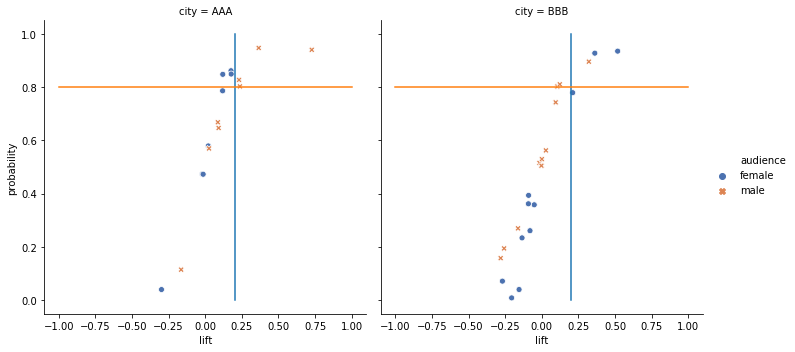

In [27]:
ax=sns.relplot(data=df, x="lift", y="probability", 
            col="city", hue="audience", style="audience", kind="scatter", palette="deep")
ax.axes[0][0].plot((0.2, 0.2), (1, 0))
ax.axes[0][1].plot((0.2, 0.2), (1, 0))
ax.axes[0][0].plot((-1, 1), (0.8, 0.8))
ax.axes[0][1].plot((-1, 1), (0.8, 0.8))
plt.show();

In [28]:
df['acceptance'] = np.where((df['lift']>=0.2) & (df['probability']>=0.8), 
                                1, 0) #20% uplift at least with 80% confidence
df.groupby(['city']).mean()

,clicks_control,clicks_target,opens_control,opens_target,lift,probability,acceptance
city,,,,,,,
AAA,30.812500,475.875000,325.062500,4260.000000,0.117425,0.651335,0.250000
BBB,33.227273,360.090909,415.272727,4405.909091,-0.001507,0.470526,0.136364


In [29]:
df.groupby(['city']).count()

,sent_week,audience,clicks_control,clicks_target,opens_control,opens_target,lift,probability,acceptance
city,,,,,,,,,
AAA,16,16,16,16,16,16,16,16,16
BBB,22,22,22,22,22,22,22,22,22


only 4 out of 16 email variations in AAA and 3 out of 22 variations in BBB are acceptable on a 20% MDE (Minimal Detectable Effect) with 80% confidence.

## Appendix & Notes
[Back to top](#Table-of-Content)